# Message Passing
Given a network with labels on some nodes, how to assign labels to all other nodes in the network? Whereas before node-embedding was used; now an alternative framework, **message passing**, will be used. This will have nodes update their own idea of what their label is based on their neighbours' labels (similar to PageRank, etc.). This is based on the intuition that individual node behaviours are correlated in the network (nearby nodes will have the same label); due to homophily (tendency of individuals to associate and bond with similar others) and influence (social connection influence individual characteristics) dependencies of graphs.

Based on thes correlations; classificaiton label of a node $v$ in the netwrok may depend on $v$'s features, the labels of $v$'s neighbours, the features of $v$'s neighbours (guilt-by-association).

## Relational Classification
Class probability $Y_v$ of node $v$ is a weighted average of class probabilities of its neighbours (unlabeled nodes initialize $Y_v=0.5$). After initialisation, update all nodes in a random order until convergence (or until maximum number of iterations reached). $$\mathbb{P}(Y_v=c)=\frac{1}{\sum_{(v,u)\in E}A_{v,u}}\sum_{(v,u)\in E}A_{v,u}\mathbb{P}(Y_u=c)$$ If edges have strength/weight information $A_{v,u}$ (edge weight between $v$ and $u$). There are chanellenges with this model; namely that convergence is not guaranteed, and that the model cannot use node feature information.

## Iterative Classification
Building on relational classifier, iterative classification trains 2 classifiers; $\phi_1(f_v)$ to predict node label based on node feature vector $f_v$, and $\phi_2(f_v,z_v)$ to predict node label based on node feature vector $f_v$ and summary $z_v$ (histogram of each label, most common label, number of different labels, etc. in $N(v)$) of labels of $v's$ neighbours, $N(v)$. The architecture is then set up in two phases:

1. **Classify based on node attributes alone**: On the training set, train classifiers (linear classifier, neural network, etc.)
    - $\phi_1(f_v)$ to predict $Y_v$ based on $f_v$
    - $\phi_2(f_v,z_v)$ to predict $Y_v$ based on $f_v$ and summary $z_v$ of labels of $v$'s neighbours.
2. **Iterate until convergence**: On the test set, for each node in graph; initialise $Y_v$ based on the classifier $\phi_1$, compute $z_v$, and predict the updated labels with $\phi_2$. Iteratively re-compute $z_v$ and $Y_v$ (now only with $\phi_2$) until class labels stabilize (or max iteration is reached).

Here too, convergence is not guaranteed.

## Belief Propogation
Belief propogation is a dynamic programming approach to answer probability queries in a graph (probability of node $u$ belonging to class $1$); where iteratively neighbour nodes 'talk' and pass messages to each other. Once a consensus is reached, the final *belief* is calculated.
This can be formally defined as $$m_{i\rightarrow j}(Y_j) = \sum_{Y_i\in\mathcal{L}}\psi(Y_i,Y_j)\phi(Y_i) \prod_{k\in N(i) / \{j\}} m_{k\rightarrow i}(Y_i),\;\forall Y_j \in\mathcal{L}$$ where the **label-label potential matrix**, $\psi$, captures the dependencies between a node and its neighbour ($\psi(Y_i,Y_j)$ is proportional to the probability of a node $j$ being in class $Y_j$ given that it has neighbour $i$ in class $Y_i$ - if graph is homophily then will have high values on the diagonal), $\phi(Y_i)$ (**Prior belief**) is proportional to the probability of node $i$ being in class $Y_i$, $m_{i\rightarrow j}(Y_j)$ being node $i$'s message/estimate of $j$ being in class $Y_j$; and $\mathcal{L}$ is the set of all classes.
This iterative calculation (with initialized messages being $1$) will eventually converge, and node $i$'s belief of being in class $Y_i$ could then be calculated via $b_i(Y_i)=\phi(Y_i)\prod_{j\in N(i)} m_{j\rightarrow i}(Y_j),\;\forall Y_j \in\mathcal{L}$.

This process (in practice) is still run even when the graph is not acyclical (messages from different subgraph are no longer independent); though it will may mean that beliefs will not converge (loops can reinforce incorrect prior beliefs).

# Graph Neural Network (GNN)
Assuming a graph $G$, with vertex set $V$, adjacency matrix $A$ (binary), node features $X\in\mathbb{R}^{m}\times\mathbb{R}^{|V|}$, and node neighbourhood $N(v),\;v\in V$; a naive approach would be to concatonate $A$ and $X$ together and feed it straight into a deep neural network. This however, is sensitive to node ordering, is not applicable to graphs of different sizes, and would require learning $O(|V|)$ parameters; thereby is not an ideal solution.

Using the prespective of an image being a strict lattice graph, some sort of (generalized) convolutional neural network may be designed to capture a general graph instead. With a traditional convolution layer, there is no fixed notion of locality (window) or transition (sliding) for a generic graph; also, as a graph does not have a canonical ordering of nodes it means that convolutional neural networks will not be a *permutation invariant/equivariant* function:

- A graph function $f:(\mathbb{R}^{|V|}\times\mathbb{R}^{|V|}, \mathbb{R}^{|V|}\times\mathbb{R}^{m})\rightarrow \mathbb{R}^{d}$ is ***permutation invariant*** if $f(A,X)=f(PAP^T,PX)$ for any permutation $P$.
- A **node** function $f:(\mathbb{R}^{|V|}\times\mathbb{R}^{|V|}, \mathbb{R}^{|V|}\times\mathbb{R}^{m})\rightarrow \mathbb{R}^{|V|}\times\mathbb{R}^{d}$ is ***permutation equivariant*** if $Pf(A,X)=f(PAP^T,PX)$ for any permutation $P$.

So instead of a sliding window, a convolutional layer is thought of as combining transformed neighbour information $h_i = \sum_{j \in N(i)}w_jh_j$, and doing so iteratively across the whole graph. A GNN *convolutional layer* (node embedding) can then be defined by determining a node of interest's **computation graph** (local network neighbourhood) and propograte/transform information from it back to compute the node features (embedding).

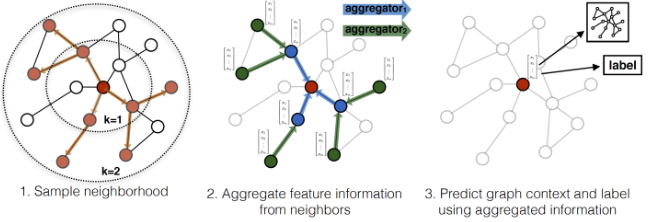

Doing so would generate a unique computation graph for each node $v$, with nodes having embeddings at each layer such that layer $k$ embeddings gets information from $N_k(v)$ (nodes which are $k$ hops away), such that if node $i\subseteq N_{k-1}(v)$, then it would get information only from $N_1(i)\subseteq N_k(v)$.

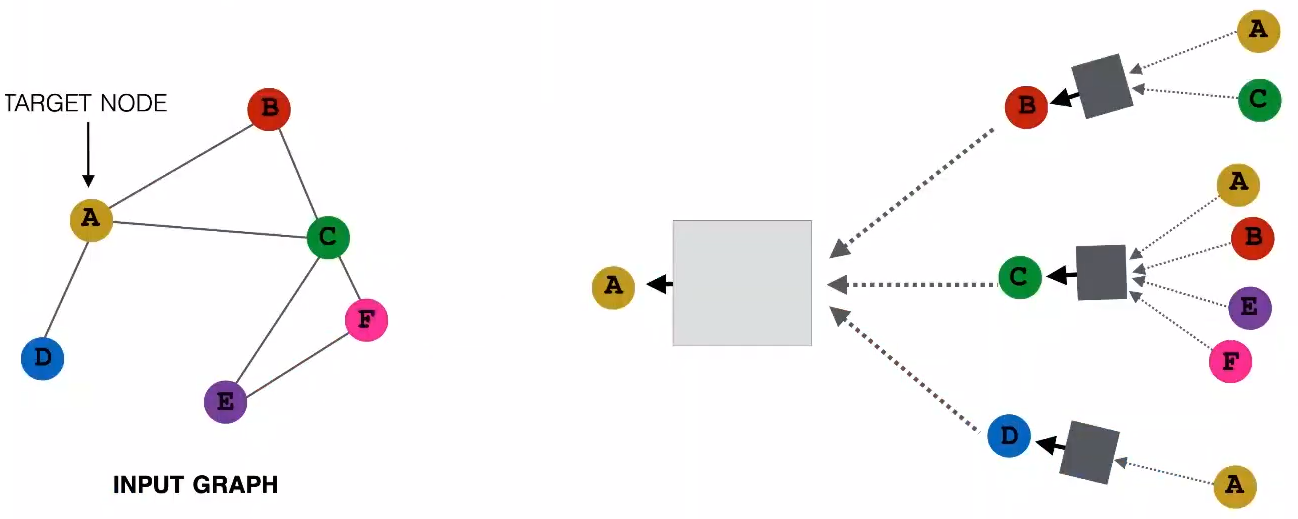

Each GNN layer then consists of; a **Message operator** which transforms a node's embedding at layer $l+1$ to a 'message' , $m_u^{(l)}=\text{MSG}^{(l)}(h_u^{(l+1)})$,for later use by other nodes, and an **Aggregation operator** which will form a single embedding (regardless of input ordering) of a node at layer $l$ from it's neighbours' messages $h_v^{(l)}=\text{AGG}^{(l)}(\{m_u^{(l)}, u\in N_1(v)\})$ (aggregation operator $f$ needs to be permutation invariant $\text{sum}(\cdot)$, $\text{mean}(\cdot)$, $\text{max}(\cdot)$, etc.).

In here, computation of $h_v^{(l)}$ does not directly depend on $h_v^{(l+1)}$, leading to the information from node $v$ itself possibly getting lost. And so a solution would be to to include $h_v^{(l+1)}$ in $h_v^{(l)}$'s computation:

1. Message - introduce a different message computation to be performed on $h_v^{(l+1)}$ only, $m_v^{(l)}=B^{(l)}h_v^{(l+1)}$.
2. Aggregation - after the neighbour aggregations, aggregate the message from node $v$ itself (via concatenation, summation, etc.), $h_v^{(l)}=\text{CONCAT}(\text{AGG}^{(l)}(\{m_u^{(l)}, u\in N_1(v)\}), m_v^{(l)})$.

Additionally, a non-linear activation function ($\sigma(\cdot)$) can be added to increase expressiveness of outputs ($\text{ReLU}(\cdot)$, $\text{Sigmoid}(\cdot)$, etc.).

## Graph Convolutional Network (GCN)
The classical approach would then be to average the neighbour messages (aggregation operator) and apply a neural network (transformation operator): $$h_{i}^{(k-1)}=\sigma(W^{(k-1)}\sum_{j\in N_1(i)}\frac{h_j^{(k)}}{|N_1(i)|}+B^{(k-1)}h_i^{(k)}),\;i\in N_{k-1}(v),\;h_i^{K}=\text{x}_i,\;\;\forall k\in\{K,\ldots,0\}$$ where the initial embedding $\text{x}_v^{(K)}$ is node $v$'s features, and the trainable parameters $W^{(k)}$ and $B^{(k)}$ are shared across the layer (not unique to $h_{i}^{(k)}$). These embeddings can be then fed into any loss function and be optimised through SGD.

- This additionally means that the GCB computation is permutation equivariant(embedding of a given node with GCN is invariant and so after permutation, the location of a given node in input node feature matrix would change but maintain its embedding value).

Furthermore, these aggregation and traqnsformation can be performed efficiently by (sparse) matrix operations: $$H^{(k)}=[h_1^{(k)},\ldots,h_{|V|}^{(k)}]^T\rightarrow\sum_{u\in N_1(v)}h_u^{(k)}=A_{(v,\,:)}H^{(k)}$$ $$D\in\mathbb{R}^{|V|}\times\mathbb{R}^{|V|}:D_{(v,v)}=d_v=|N_1(v)|\rightarrow D^{-1}\in\mathbb{R}^{|V|}\times\mathbb{R}^{|V|}:D^{-1}_{(v,v)}=1/|N_1(v)|$$ $$\therefore \sum_{u\in N_1(v)}\frac{h_u^{(k)}}{|N(v)|}=D^{-1}AH^{(k)}\rightarrow\;H^{(k-1)}=\sigma(\underbrace{\color{red} D^{-1}AH^{(k)}W_k^T \color{black}}_{\text{neighbour aggregation}}+\overbrace{\color{blue} H^{(k)}B_k^T \color{black}}^{\text{self transform}})$$
In practice, this implies that efficient sparse matrix multiplication can be used ($\tilde{A}=D^{-1}A$ is sparse). However, not all GNNs can eb expressed in a simple matrix form (when aggregation function is complex).

## GraphSAGE
$$h_v^{(l-1)}=\sigma(W^{(l-1)}\cdot\text{CONCAT}[h_v^{(l)}, \text{AGG}(\{h_u^{l},\forall u\in N_1(v)\})])$$
GraphSAGE builds on the GCN; extending it by maintaining an arbitrary aggregation operator (allows for multiple choices, not only average like in GCN), and concatonating the self-transform message with the aggregated neighbour messages (adds a lot of expressive power). 
Additionally, $L_2$ normalization can be optionally applied to $h_v^{(l)}$ at every layer ($||u||_2=\sqrt{\sum_iu_i^2}\rightarrow h_v^{(l)}=\frac{h_v^{(l)}}{||h_v^{(l)}||_2}$) to ensure its sum will always be 1 (without it, embedding vectors will have different scales). In some cases (not always), normalization of embedding results in performance improvement.

## Graph Attention Network (GAN)
$$h_v^{(l-1)}=\sigma(\sum_{u\in N_1(v)}\alpha_{vu}W^{(l-1)}h_u^{(l)})$$
This architecture builds on GCN by instead assigning equal importance to every neighbour of $v$ ($\frac{1}{|N_1(v)|}$), it defines an *attention weight* (inspired by cognitive attention), $\alpha_{vu}$, for each $u\in N_1(v)$ that is either explicitly based on structural properties of graph, or a learned parameter.

### Learned Attention Weight
Let $\alpha_{vu}$ be computed as a byproduct of an **attention mechanism** $a$ which computes **attention coefficients** $e_{vu}$ across pairs of nodes $u$, and $v$ based on their messages: $e_{vu}$ indicates the importance of $u$'s message to node $v$
$$e_{vu}=a(W^{(l-1)}h_u^{(l)},W^{(l-1)}h_v^{(l)})\rightarrow\alpha_{vu}=\frac{\exp{e_{vu}}}{\sum_{k\in N_1(v)}\exp{e_{vk}}}$$
Softmax is used to normalize $e_{vu}$ into the final attention weight so that $\sum_{u\in N_1(v)}\alpha_{vu}=1$.

the form of the attention mechanism (choice of $a$) is commonly a single-layer neural network ($a(\cdot,\cdot)=\text{Linear}(\text{Concat}(\cdot,\cdot))$), thereby is able to be trained jointly (due to chain-rule backpropogation) with the other trainable parameters of the model in an end-to-end fashion.

#### Multi-head Attention
While the normal attention mechanism is a good approach, in practice it can be difficult to work with due to instability (hard to make model converge). To overcome it, expanding the notion of attention can help to stabalize the learning process. This is done by creating multiple attention scores (each replica with a different set of parameters) $h_v^{(l-1)}[i]=\sigma(\sum_{u\in N_1(v)}\alpha_{vu}^iW^{(l-1)}h_u^{(l)})$ and have the outputs aggregated $h_v^{(l)}=\text{AGG}(\{h_v^{(l)}[i], i\in\{1,\ldots,n\}\})$ (concatenation, summation, etc.).

## Deep Learning Modules
In practice, better performance is achieved by considering a general GNN layer design which can utilise the above architectures together; additionally including modern deep learning modules that proved to be useful in other domains.

### Batch Normalization
Given a batch of inputs (embeddings), $X\in\mathbb{R}^N\times\mathbb{R}^D$, they can be re-centred and re-scaled , $\hat{X}_{i,j}=\frac{X_{i,j}-\mu_j}{\sqrt{\sigma_j^2+\epsilon}}\rightarrow Y_{i,j}=\gamma_j\hat{X}_{i,j}+\beta_j,\;\mu_j=\frac{1}{N}\sum_{i=1}^{N}X_{i,j},\;\sigma_j^2=\frac{1}{N}\sum_{i=1}^{N}(X_{i,j}-\mu_j)^2$ and $\gamma,\beta\in\mathbb{R}^D$ are trainable parameters, in order to stabalize the neural network training by preventing embedding/parametrs from exponentially increasing/decreasing in value.

### Dropout
During training, randomly zeroes some of the neurons (turn off) with some probability p (chosen independently for each forward call and are sampled from a Bernoulli distribution). This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons (overfitting). During testing all neurons are used for computation.
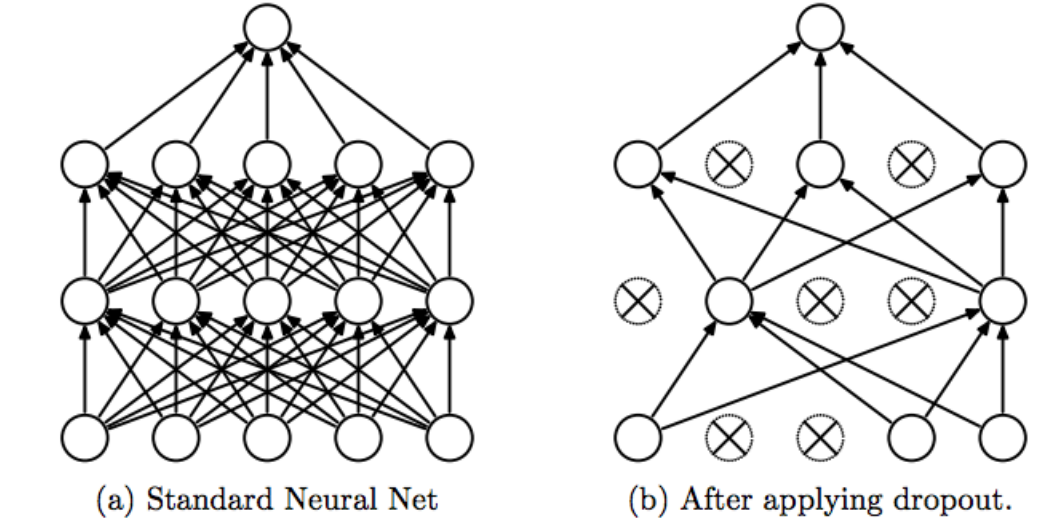
### GNN Layer Stacking
The standard method of adding complexity to a GNN model is to sequentially adding GNN layers (increase number of steps), there is a limit however on how many layers can be added; this is due to GNN suffering from the **over-smoothing problem** (all node embeddings converge to the same value), making it impossible to differentiate nodes. Over-smoothing occurs as each node's _receptive field_ (set of nodes that determine the embedding of a node of interest) become the same (receptive field overlap grows) as the number of hops (GNN layers) increase; as the embedding of a node is determined by its receptive field, it would mean that as the number of GNN layers increase, the nodes' receptive fields will become similar to each other (even when nodes are not similar) causing their embeddings to be also similar. Therefore be cautious when adding GNN layers, as unlike NNs in other domains adding more GNN layers does not always help; analyze the necessary receptive field (compute diameter of graph), and set the number of layers to be a bit more than it.
#### Expressive Power for Shallow GNNs
Whereas before the the Transformation and Aggregation functions only included one linear layer (matrix multiplication), these can be replaces with Multi-Layer-Perceptrons (MLP aka deep neural networks); thereby add expressiveness to the network without increasing the number of layers.

Alternatively (or additionally), **pre-processing** (important when encoding node features is necessary - images, text, etc.) and/or **post-processing** (important when reasoning/transformation over node embedding are needed - graph classification, knowledge graphs, etc.) layers (MLPs) can be added onto the GNN which do not pass messages; thereby prevent over-smoothing while increasing expressiveness (works great practically).

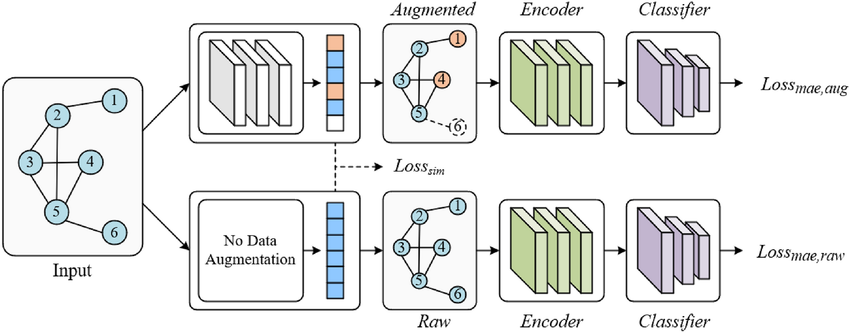

Furthermore, Adding skip connections in GNNs can increase expressiveness. From over-smoothing, it can be seen that node embeddings in earlier GNN layers can better differentiate nodes (sometimes); and so the impact of earlier layers on the final node embeddings can be icreased by adding shortcuts in the GNN, $h_v^{(l-1)}=h_v^{(l-1)}+h_v^{(l)}$. This method creates a mixture model (of shallow and deep GNNs) where $N$ skipp connections translate into $2^N$ possible paths (with each having upto $N$ modules). These skip connections do not have to skip a single layer (skip directly to the last layer).

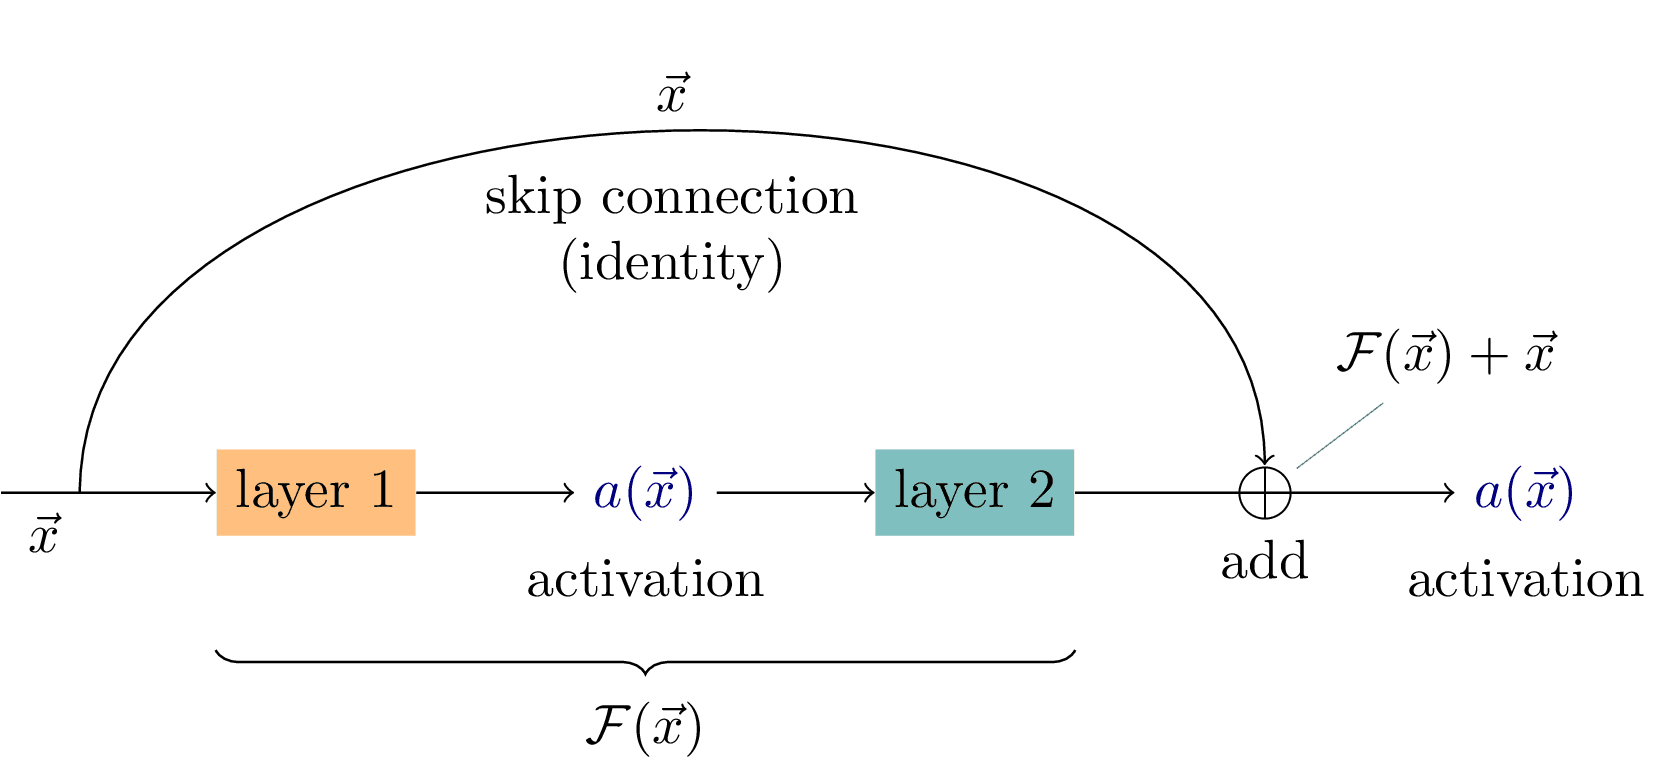

## Graph Augmentation for GNN
The general GNN frameworks is based on the assumption that the computation graph (base of GNN) is directly taken from the raw input graph. This assumption can be overturned to alleviate an input graph's lack of features, a graph that is too sparse (inefficient message passing), or dense (message passing too costly), or large (cannot fit computation graph into GPU); it is also unlikely that the input graph happens to be the optimal computation graph for embeddings, and thereby the breaking of this assumption can help improve model performance. 
### Graph Feature Augmentation

### Graph Structure Augmentation